In [1]:
import sys
sys.path.append('..')
from src.pomdp import *
from src.mdp import VI_Solver

import numpy as np

# POMDP Toy Problem

Symmetric 2 state, 2 action model

## Model definition

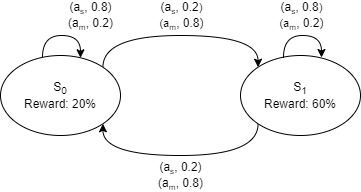

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [5]:
REWARD_PROBS = [0.2, 0.6]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p,:] = REWARD_PROBS[s_p]
        
reward_table

array([[[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]],


       [[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]]])

In [6]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = Model(states, actions, observations, transition_table, reward_table, observation_table, probabilistic_rewards=True)

## Solving

In [7]:
solver = PBVI_Solver(eps=0.001)

In [8]:
value_function, solve_history = solver.solve(model,9,10)

Converged early...


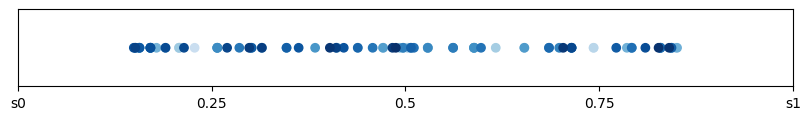

In [9]:
solve_history.plot_belief_set(10)

In [10]:
value_function

[AlphaVector([4.30527884, 4.54527884]),
 AlphaVector([4.30458353, 4.54582799]),
 AlphaVector([4.30054278, 4.54733669]),
 AlphaVector([4.54582799, 4.30458353]),
 AlphaVector([4.3046335 , 4.54579763]),
 AlphaVector([4.54733669, 4.30054278]),
 AlphaVector([4.27993638, 4.55239109]),
 AlphaVector([4.54579763, 4.3046335 ]),
 AlphaVector([4.55239109, 4.27993638]),
 AlphaVector([4.54582261, 4.30459399]),
 AlphaVector([4.54527884, 4.30527884]),
 AlphaVector([4.17193638, 4.57399109]),
 AlphaVector([4.30076873, 4.54726293]),
 AlphaVector([4.54726293, 4.30076873]),
 AlphaVector([4.57399109, 4.17193638]),
 AlphaVector([4.30459399, 4.54582261]),
 AlphaVector([4.54579605, 4.30463565]),
 AlphaVector([4.30463565, 4.54579605])]

<Figure size 600x400 with 0 Axes>

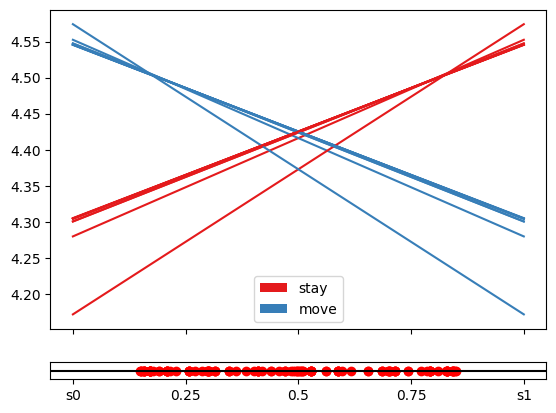

In [11]:
solve_history.plot_solution(4)

In [12]:
# solve_history.save_history_video()

## Simulation

In [13]:
agent = Agent(model)
agent.train(solver, 9, 10)

Converged early...


In [14]:
sim = Simulation(model)
rewards = agent.simulate(sim, 1000)

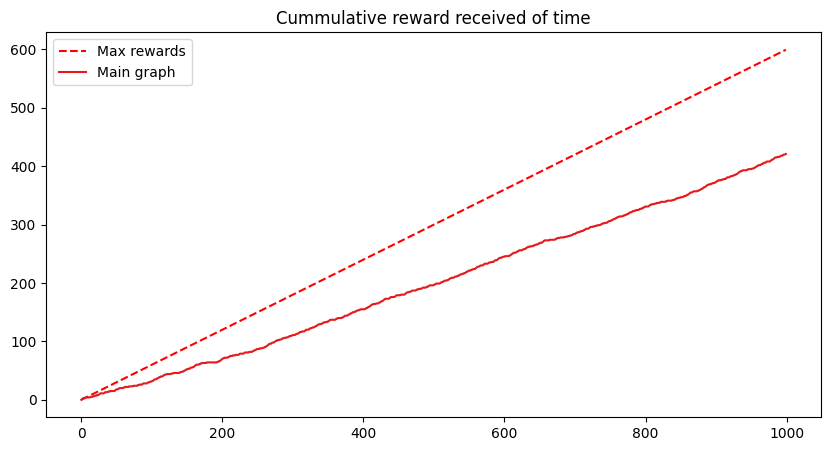

In [15]:
rewards.plot(type='total', max_reward=max(REWARD_PROBS))

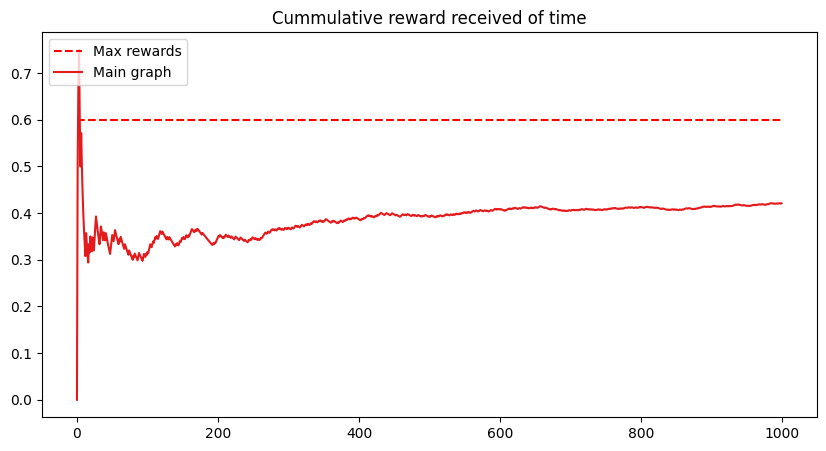

In [16]:
rewards.plot(type='moving_average', max_reward=max(REWARD_PROBS))

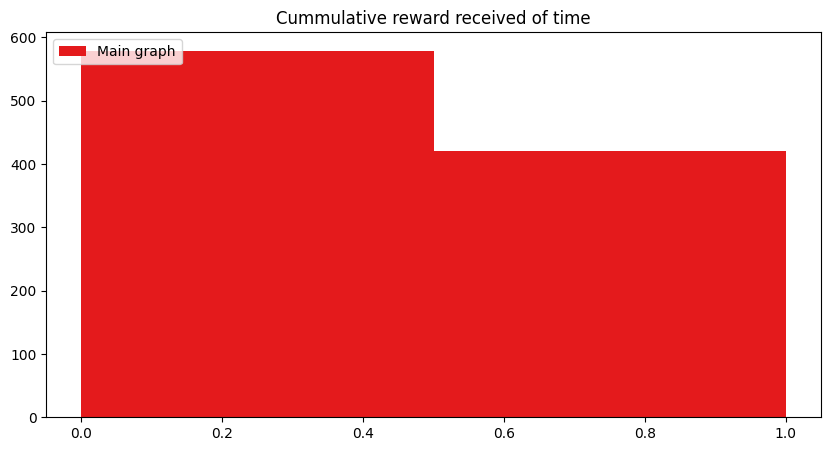

In [17]:
rewards.plot(type='histogram', max_reward=max(REWARD_PROBS))

## MDP Version of the probelm

In [18]:
vi_solver = VI_Solver(gamma=0.9)

In [19]:
vi_solution, vi_solve_history = vi_solver.solve(model)

In [20]:
# solve_history.save_history_video(custom_name='comparison', compare_with=vi_solve_history)